## EDA for Sessions Dataset
- Session = when a user is on the app

In [1]:
import pandas as pd
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in data using pandas

In [3]:
df0 = pd.read_csv("/Users/Reagan/Dropbox/zleanplum_data/sessions.csv")

In [281]:
# drop irrelevant columns (may add back in the future)

In [4]:
df0.drop(['app_id',"device_id","latitude","longitude",
         'is_wau','is_mau','timezone',
         'timezone_offset','os_name','locale','session_id'], axis=1, inplace=True)

In [5]:
df=df0.copy()

In [6]:
# timestamps
# create (weekofday, month, day) for start_timestamp; create (how many days is sign-up day from dec1) 

In [7]:
df['start_timestamp'] = df['start_timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
df['user_created_timestamp'] = df['user_created_timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))

df['st_weekday']=df['start_timestamp'].dt.weekday
df['st_month']=df['start_timestamp'].dt.month
df['st_day']=df['start_timestamp'].dt.day

dec1 = datetime(2018, 12, 15, 00, 00, 00,0)  # here is dec 15th
df['cr_from_now'] = df['user_created_timestamp'].apply(lambda x: pd.Timedelta(dec1 - x).days)

In [8]:
df.drop(['start_timestamp','user_created_timestamp'],axis=1, inplace=True)

In [9]:
# delete those offline session. 

In [10]:
# df = df[df['is_session']==True]
# df.drop('is_session',axis=1, inplace=True)

In [11]:
df.head()

,previous_sessions_duration,is_user_first_session,is_session,is_developer,country,region,city,session_index,user_id_hash,st_weekday,st_month,st_day,cr_from_now
0,25837591,False,True,False,PH,00,makati,30,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2,11,14,69
1,35050130,False,True,False,PH,00,quezon city,47,9943447915df3a45fd6720a026af905b6da6b56a37701b...,5,12,1,69
2,11343848,False,True,False,PH,00,makati,10,9943447915df3a45fd6720a026af905b6da6b56a37701b...,2,10,10,69
3,13499724,False,True,False,PH,11,davao city,13,9943447915df3a45fd6720a026af905b6da6b56a37701b...,6,10,21,69
4,32788010,False,True,False,PH,00,makati,41,9943447915df3a45fd6720a026af905b6da6b56a37701b...,0,11,19,69


## The number of unique user

In [61]:
df['user_id_hash'].nunique()  

621106

There are 621106 unique users in total.

# Geo information

In [71]:
df['region'].nunique()

755

In [72]:
df['country'].nunique()

228

In [78]:
df['city'].nunique()

31556

In [77]:
len(df.groupby(['country','city']).size().reset_index())

32934

The number of unique combination of country and city is 32934, but the number of unique region is 755. It indicates that many cities are belonging to the same region. 

# The number of online session and offline session

Text(0, 0.5, 'Frequency')

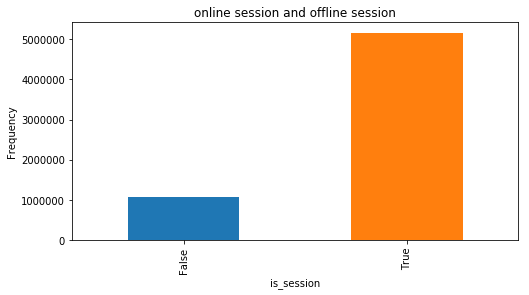

In [62]:
ax = df0['is_session'].value_counts().sort_index().plot(kind='bar',
                                    figsize=(8,4),
                                    title="online session and offline session")
ax.set_xlabel("is_session")
ax.set_ylabel("Frequency")

We will delete all those offline sessions when doing feature engineering.

# The number of developers 

Text(0, 0.5, 'Frequency')

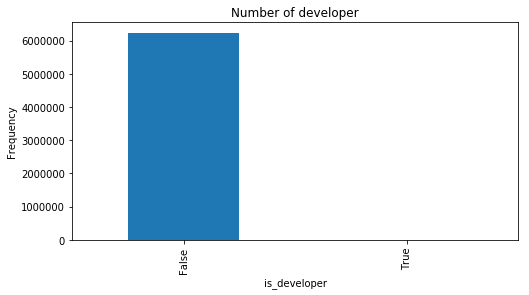

In [63]:
ax = df['is_developer'].value_counts().sort_index().plot(kind='bar',
                                    figsize=(8,4),
                                    title="Number of developer")
ax.set_xlabel("is_developer")
ax.set_ylabel("Frequency")

It seems that there is no developers at all, which is a bit weird. So we write a query to see the number of developers in the data.

In [64]:
df['is_developer'].value_counts()

False    6237248
True        2588
Name: is_developer, dtype: int64

As we can see, actually there are 2588 users that are developer even though we can not spot that on the histogram

# Number of first session

Text(0, 0.5, 'Frequency')

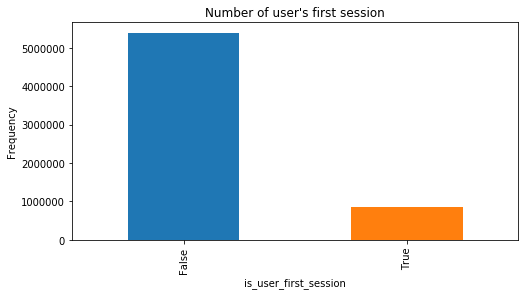

In [65]:
ax = df['is_user_first_session'].value_counts().sort_index().plot(kind='bar',
                                    figsize=(8,4),
                                    title="Number of user's first session")
ax.set_xlabel("is_user_first_session")
ax.set_ylabel("Frequency")

Most of the sessions are not the first session of our users.

# Which weekdays did the sessions happen?

Text(0, 0.5, 'Frequency')

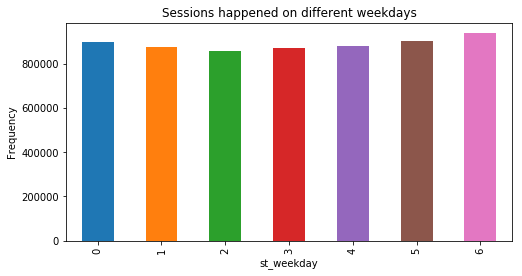

In [68]:
ax = df['st_weekday'].value_counts().sort_index().plot(kind='bar',
                                    figsize=(8,4),
                                    title="Sessions happened on different weekdays")
ax.set_xlabel("st_weekday")
ax.set_ylabel("Frequency")

From the plot, we know that saturday(5) and sunday(6) have slightly more sessions than other days. We may take whether or not the session happened on weekend as one of the features.

# How many days between sign up day and "now" (The distribution of it)

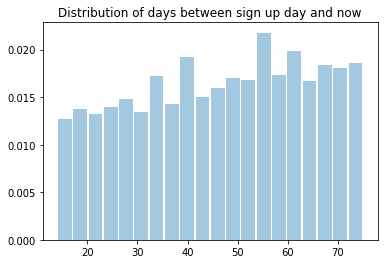

In [83]:
num_bins = 20
plt.hist(df['cr_from_now'], num_bins, normed=1, alpha=0.4, rwidth=0.9)
plt.title("Distribution of days between sign up day and now")
plt.show()

# convert this data to spark
## reconstruct the data and then explore

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql import functions as f
from pyspark.sql import Window
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType
from pyspark.sql import SQLContext
ss = SparkSession.builder.getOrCreate()

In [13]:
myschema= StructType([ StructField("previous_sessions_duration", IntegerType(), True)\
                       ,StructField("is_user_first_session", StringType(), True)\
                       ,StructField("is_developer", StringType(), True)\
                       ,StructField("is_session", StringType(), True)\
                       ,StructField("region", StringType(), True)\
                       ,StructField("session_index", IntegerType(), True)\
                       ,StructField("user_id_hash", StringType(), True)\
                       ,StructField("st_weekday", IntegerType(), True)\
                       ,StructField("st_month", IntegerType(), True)\
                       ,StructField("st_day", IntegerType(), True)\
                       ,StructField("cr_from_now", IntegerType(), True)])

In [20]:
path = '/Users/Reagan/Dropbox/SF_DS/COURSE/5.630_advanced_ml/final project/session_step1_full5.csv'
spark_df = ss.read.csv(path,schema=myschema,header = True)

In [21]:
# convert user_id_hash to integers
userid = pd.read_csv('/Users/Reagan/Downloads/user_dict.csv', header=None)
userid_dict = {row[1][0]:row[1][1] for row in userid.iterrows()}
fn = UserDefinedFunction(lambda x: userid_dict[x], IntegerType())
spark_df = spark_df.withColumn('id_', fn(spark_df.user_id_hash)).drop('user_id_hash')
# convert T/F to 1/0 for "is_user_first_session" and "is_developer"
TF_dict ={"True":1, "False":0}
fn3 = UserDefinedFunction(lambda x: TF_dict[x], IntegerType())
spark_df = spark_df.withColumn('is_user_first_session2', fn3(spark_df.is_user_first_session)).drop('is_user_first_session')
spark_df = spark_df.withColumn('is_developer2', fn3(spark_df.is_developer)).drop('is_developer')
spark_df = spark_df.withColumn('is_session2', fn3(spark_df.is_session)).drop('is_session')

# agg 1 
cr = spark_df.groupBy('id_').agg(avg("cr_from_now").alias("cr_from_now")).cache()  
# agg 2
developer = spark_df.groupBy('id_').agg(max("is_developer2").alias("is_developer3")).cache()  #becuz of an annoying user
# agg 3
cnts = spark_df.groupBy(['id_','region']).agg(count("id_").alias('count')).cache()
w = Window.partitionBy('id_')
region = cnts.withColumn('max_count', f.max('count').over(w)).where(f.col('count') == f.col('max_count')).cache() # we have some id that its region has multiple mode.
region = region.dropDuplicates(subset = ['id_']).select('id_','region')
# agg 4
last2week_ss_duration = spark_df.filter(spark_df.st_month==12).filter(spark_df.st_day < 15).groupBy('id_').agg(sum("previous_sessions_duration").alias("last2week_ss_duration")).cache()
# agg 5
total = spark_df.groupBy('id_').agg(count("id_").alias("total_count")).cache()
# agg 6
last2week = spark_df.filter(spark_df.st_month==12).filter(spark_df.st_day < 15).groupBy('id_').agg(count("id_").alias("last2week_count")).cache()
# agg 7
last5day = spark_df.filter(spark_df.st_month==12).filter(spark_df.st_day > 10).filter(spark_df.st_day < 15).groupBy('id_').agg(count("id_").alias("last5day_count")).cache()
# agg 8 
weekend = spark_df.filter((spark_df.st_weekday==5) | (spark_df.st_weekday==6)).groupBy('id_').agg(count("id_").alias("weekend_count")).cache()
# agg 9
weekday = spark_df.filter((spark_df.st_weekday==0) | (spark_df.st_weekday==1) | (spark_df.st_weekday==2)| (spark_df.st_weekday==3) | (spark_df.st_weekday==4)).groupBy('id_').agg(count("id_").alias("weekday_count")).cache()

# make the table by joining these agg results together
join0 = cr.join(region, on='id_', how='left')
join1 = join0.join(last2week_ss_duration, on='id_', how='left') 
join2 = join1.join(total, on='id_', how='left') 
join3 = join2.join(last2week, on='id_', how='left') 
join4 = join3.join(last5day, on='id_', how='left') 
join5 = join4.join(weekend, on='id_', how='left')
ss_features = join5.join(weekday, on='id_', how='left').cache()


In [25]:
ss_features.show(3)

+---+-----------+------+---------------------+-----------+---------------+--------------+-------------+-------------+
|id_|cr_from_now|region|last2week_ss_duration|total_count|last2week_count|last5day_count|weekend_count|weekday_count|
+---+-----------+------+---------------------+-----------+---------------+--------------+-------------+-------------+
|148|       43.0|    is|                 null|          6|           null|          null|            3|            3|
|463|       56.0|    il|                 null|          1|           null|          null|         null|            1|
|471|       56.0|    fy|                 null|          4|           null|          null|            3|            1|
+---+-----------+------+---------------------+-----------+---------------+--------------+-------------+-------------+
only showing top 3 rows



# Convert back to Pandas and do EDA

In [26]:
sf = ss_features.toPandas()

In [29]:
# sf.to_csv('groupby_user_withSpark_then_EDA.csv', encoding='utf-8', index=False)

In [31]:
sf['last2week_ss_duration'].fillna(0, inplace=True)
sf['total_count'].fillna(0, inplace=True)
sf['last2week_count'].fillna(0, inplace=True)
sf['last5day_count'].fillna(0, inplace=True)
sf['weekend_count'].fillna(0, inplace=True)
sf['weekday_count'].fillna(0, inplace=True)

In [46]:
labels7 = pd.read_csv('labels7.csv')

In [49]:
labels7['id_']=labels7['user_id']
labels7 = labels7.drop(['user_id'], axis=1)

In [53]:
sf.head(2)

,id_,cr_from_now,region,last2week_ss_duration,total_count,last2week_count,last5day_count,weekend_count,weekday_count
0,148,43.0,is,0.0,6,0.0,0.0,3.0,3.0
1,463,56.0,il,0.0,1,0.0,0.0,0.0,1.0


In [54]:
labels7.head(2)

,label,id_
0,0,0
1,0,1


In [56]:
eda = pd.merge(sf, labels7, on='id_')
eda.head(2)

,id_,cr_from_now,region,last2week_ss_duration,total_count,last2week_count,last5day_count,weekend_count,weekday_count,label
0,148,43.0,is,0.0,6,0.0,0.0,3.0,3.0,0
1,463,56.0,il,0.0,1,0.0,0.0,0.0,1.0,0


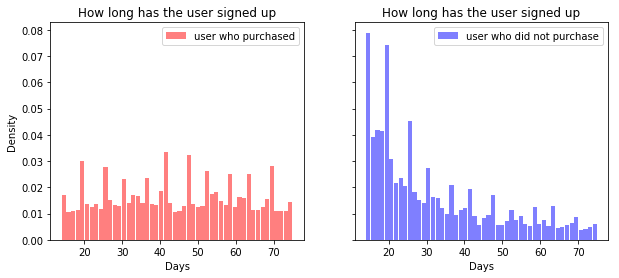

In [184]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['cr_from_now'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who purchased')
ax2.hist(eda[eda['label']==1]['cr_from_now'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who did not purchase')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('How long has the user signed up')
ax2.set_title('How long has the user signed up')
ax1.set_xlabel('Days')
ax2.set_xlabel('Days')
ax1.set_ylabel('Density')
txt = None

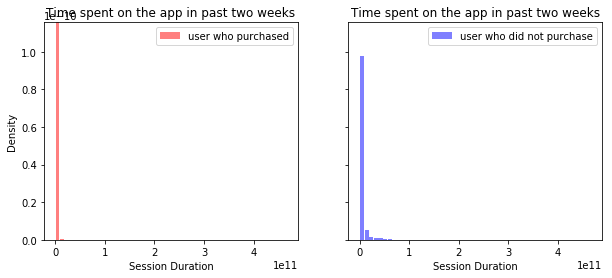

In [185]:
num_bins = 50
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['last2week_ss_duration'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who purchased')
ax2.hist(eda[eda['label']==1]['last2week_ss_duration'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who did not purchase')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('Time spent on the app in past two weeks')
ax2.set_title('Time spent on the app in past two weeks')
ax1.set_xlabel('Session Duration')
ax2.set_xlabel('Session Duration')
ax1.set_ylabel('Density')
# ax1.set_xlim([0, 2])
# ax2.set_xlim([0, 2])
txt = None

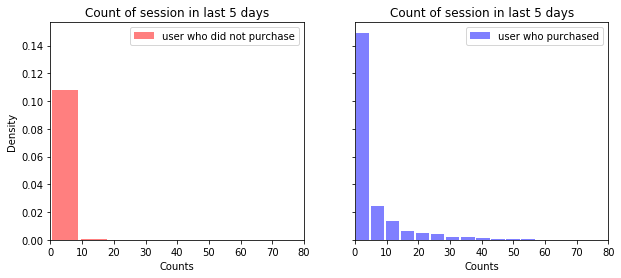

In [188]:
num_bins = 20
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['last5day_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who did not purchase')
ax2.hist(eda[eda['label']==1]['last5day_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who purchased')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('Count of session in last 5 days')
ax2.set_title('Count of session in last 5 days')
ax1.set_xlabel('Counts')
ax2.set_xlabel('Counts')
ax1.set_ylabel('Density')
ax1.set_xlim([0, 80])
ax2.set_xlim([0, 80])
txt = None

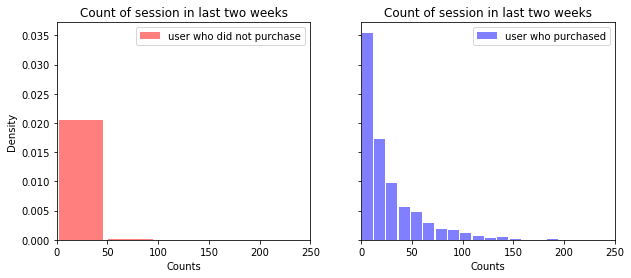

In [190]:

num_bins = 20
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['last2week_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who did not purchase')
ax2.hist(eda[eda['label']==1]['last2week_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who purchased')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('Count of session in last two weeks')
ax2.set_title('Count of session in last two weeks')
ax1.set_xlabel('Counts')
ax2.set_xlabel('Counts')
ax1.set_ylabel('Density')
ax1.set_xlim([0, 250])
ax2.set_xlim([0, 250])
txt = None

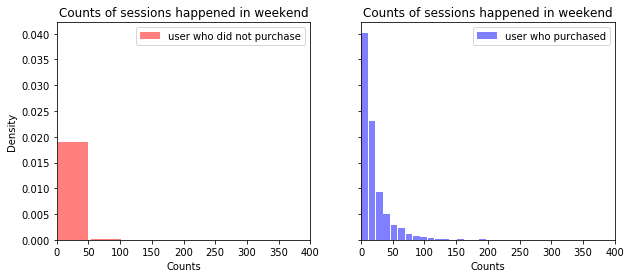

In [191]:
num_bins = 20
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['weekend_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who did not purchase')
ax2.hist(eda[eda['label']==1]['weekend_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who purchased')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('Counts of sessions happened in weekend')
ax2.set_title('Counts of sessions happened in weekend')
ax1.set_xlabel('Counts')
ax2.set_xlabel('Counts')
ax1.set_ylabel('Density')
ax1.set_xlim([0, 400])
ax2.set_xlim([0, 400])
txt = None

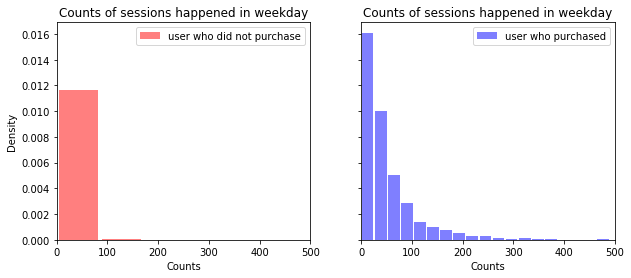

In [193]:
num_bins = 30
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
ax1.hist(eda[eda['label']==0]['weekday_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='red',label='user who did not purchase')
ax2.hist(eda[eda['label']==1]['weekday_count'], num_bins, normed=1, alpha=0.5, rwidth=0.9, color='blue',label='user who purchased')
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_title('Counts of sessions happened in weekday')
ax2.set_title('Counts of sessions happened in weekday')
ax1.set_xlabel('Counts')
ax2.set_xlabel('Counts')
ax1.set_ylabel('Density')
ax1.set_xlim([0, 500])
ax2.set_xlim([0, 500])
txt = None